## Project: Plant Seedlings

In this project I build two models based on a tailored made Convolutional Neural Network and a pre-trained model based on the VGG19 model.

Used Dataset from: https://www.kaggle.com/datasets/vbookshelf/v2-plant-seedlings-dataset

The model is trained on food images to distinguish plant seeds divided in 12 classes: Black Grass, Charlock, Cleavers, Common Chickweed, Common Wheat, Fat Hen, Loose Silky Bent, Maize, Scentless Mayweed, Shepherd Purse, Small flowered Cranesbill, and Sugar Beet.

<ul>
    <li>Table of Content
        <ul>
            <li>Download Images</li>
            <li>Build the Model</li>
            <li>Train the Model</li>
            <li>Model Performance</li>
            <li>Report Results</li>
        </ul>
    </li>
    
</ul>

First, we will import important models and the ImageDataGenerator module since we will be leveraging it to train our model in batches.

In [2]:
!python3 --version

Python 3.11.9


In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime 

In [19]:
# set a random state number
rs = 42

os.environ['PYTHONHASHSEED']=str(rs)
import random
random.seed(rs)
np.random.seed(rs)


# set the path for the data base containing the images
file_path = "/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/"

#check existence of the path
os.path.isdir(file_path)

True

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

### Shuffle images from directory into train, valid, and test sets

In [9]:
# Define paths
main_dir = file_path+'main'
train_dir = file_path+'train'
val_dir = file_path+'valid'
test_dir = file_path+'test'

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Ensure ratios sum to 1
assert train_ratio + val_ratio + test_ratio == 1

In [10]:
if os.path.isdir(train_dir):
    print("Dir exist")
else:
    # Iterate through each class
    for class_dir in os.listdir(main_dir):
        class_path = os.path.join(main_dir, class_dir)
        if os.path.isdir(class_path):
            # Create train, val, test directories for the class
            os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
            os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
            os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
        
            # Get all images in the class directory as a list of strings
            images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        
            # Shuffle and split data
            train_imgs, test_imgs = train_test_split(images, test_size=(1-train_ratio), shuffle=True, 
                                                 random_state=rs)
            val_imgs, test_imgs = train_test_split(test_imgs, test_size=(test_ratio/(val_ratio+test_ratio)), 
                                               shuffle=True,random_state=rs)
        
            # Copy files to corresponding directories
            for img in train_imgs:
                shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_dir, img))
            for img in val_imgs:
                shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_dir, img))
            for img in test_imgs:
                shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_dir, img))

Dir exist


In [11]:
# Print the count of items from each class

count = 0
for folder in os.listdir(main_dir):
    folder_pics = len(os.listdir(os.path.join(main_dir, folder)))
    print("The", folder, "class has", folder_pics, "pictures.")
    count += folder_pics

print(count,'total images')

The Shepherd_Purse class has 274 pictures.
The Cleavers class has 335 pictures.
The Loose_Silky-bent class has 762 pictures.
The Common_Chickweed class has 713 pictures.
The Scentless_Mayweed class has 607 pictures.
The Sugar_beet class has 463 pictures.
The Black-grass class has 309 pictures.
The Fat_Hen class has 538 pictures.
The Small-flowered_Cranesbill class has 576 pictures.
The Common_wheat class has 253 pictures.
The Charlock class has 452 pictures.
The Maize class has 257 pictures.
5539 total images


## Let us have a look at the classes we are going to classify

In [50]:
# set up a dictionary with {class:image_path} taking a random image from each directory

image_examples_dict = {}
for folder in os.listdir(main_dir):
    pics = random.choice(os.listdir(os.path.join(main_dir, folder)))
    path_pic = os.path.join(main_dir, folder, pics)
    class_pic = folder
    image_examples_dict.update({class_pic: path_pic})

print(image_examples_dict)

{'Shepherd_Purse': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Shepherd_Purse/206.png', 'Cleavers': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Cleavers/304.png', 'Loose_Silky-bent': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Loose_Silky-bent/206.png', 'Common_Chickweed': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Common_Chickweed/532.png', 'Scentless_Mayweed': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Scentless_Mayweed/294.png', 'Sugar_beet': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Sugar_beet/36.png', 'Black-grass': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Black-grass/278.png', 'Fat_Hen': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Fat_Hen/498.png', 'Small-flowered_Cranesbill': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Small-flowered_Cranesbill/509.png', 'Common_wheat': '/Users/brncat/Downloads/AltaVerde/GitHub/seeds_db/main/Common_wheat/258.png', 'Charlock': '/User

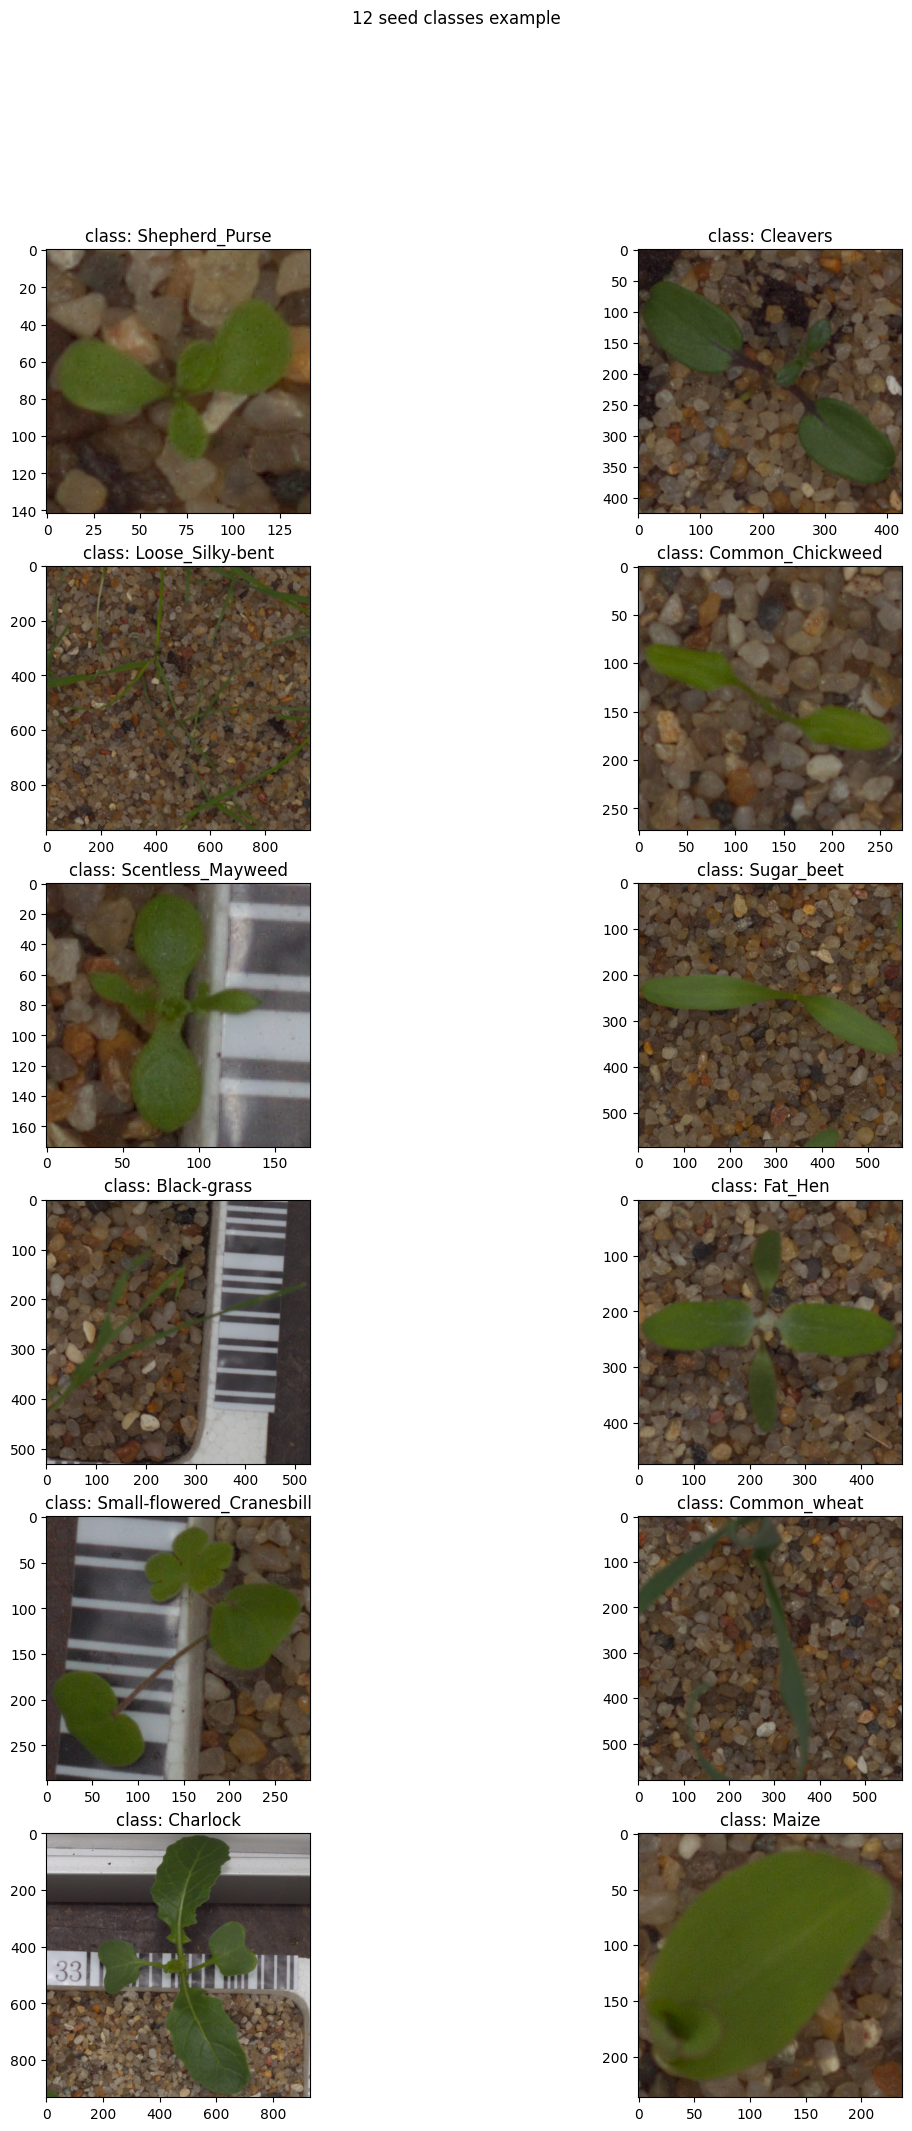

In [51]:
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(14, 24)) # define your figure and axes

ind = 0
for ax1 in axs:
    for ax2 in ax1:
        batch_image = list(image_examples_dict.items())
        image_data = plt.imread(batch_image[ind][1])
        ax2.imshow(image_data)
        ax2.set_title('class: {}'.format(batch_image[ind][0]))
        ind += 1

fig.suptitle('12 seed classes example')
plt.show()

## Model definition


In [8]:
# here I define some important parameter that are going to be used in both models

num_classes = 12

image_resize = 224

batch_size_training = 8
batch_size_validation = 8

In [9]:
# instantiate the image data generator
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

Now we can generate train and validation set with ImageDataGenerator

In [12]:
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_training,
    class_mode='categorical',
    seed=rs
    )

Found 3872 images belonging to 12 classes.


In [13]:
validation_generator = data_generator.flow_from_directory(
    val_dir,
    target_size=(image_resize, image_resize),
    batch_size=batch_size_validation,
    class_mode='categorical',
    seed=rs
)

Found 830 images belonging to 12 classes.


In [14]:
class_names = {y: x for x, y in validation_generator.class_indices.items()}
class_names

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common_Chickweed',
 4: 'Common_wheat',
 5: 'Fat_Hen',
 6: 'Loose_Silky-bent',
 7: 'Maize',
 8: 'Scentless_Mayweed',
 9: 'Shepherd_Purse',
 10: 'Small-flowered_Cranesbill',
 11: 'Sugar_beet'}

Here we define some optimization parameters that are going to be used with both models.

In [15]:
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(validation_generator)
num_epochs = 5
print(steps_per_epoch_training,steps_per_epoch_validation)

484 104


## Build the model

### we start with the tailored-made CNN model

In [16]:
input = Input(shape=(image_resize,image_resize,3,)) # (None,224,224,3)

conv1 = Conv2D(32,(5,5),activation='relu',padding="same")(input) # (None,224,224,32)
pool1 = MaxPooling2D(pool_size=(2,2))(conv1) # (None,112,112,32)

conv2 = Conv2D(64,(3,3),activation='relu',padding="same")(pool1) # (None,112,112,64)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2) # (None,56,56,64)

conv3 = Conv2D(32,(3,3),activation='relu',padding="same")(pool2) # (None,56,56,32)
pool3 = MaxPooling2D(pool_size=(2,2))(conv3) # (None,28,28,32)

conv4 = Conv2D(32,(3,3),activation='relu',padding="same")(pool3) # (None,28,28,32)
pool4 = MaxPooling2D(pool_size=(2,2))(conv3) # (None,28,28,32)

conv4 = Conv2D(32,(3,3),activation='relu',padding="same")(pool4) # (None,28,28,64)
pool4 = MaxPooling2D(pool_size=(2,2))(conv4) # (None,14,14,32)

flat = Flatten()(pool4) # (None, 6272)

drop = Dropout(0.2)(flat) # (None, 6272)

fully = Dense(512,activation='relu')(drop) # (None, 512)
pred = Dense(num_classes,activation='softmax')(fully) # (None, 2)

model_cnn = Model(inputs=input, outputs=pred)

model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464 

In [17]:
model_cnn.layers

In [18]:
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
%%time
fit_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
)

Epoch 1/8
484/484 [==============================] - 59s 121ms/step - loss: 2.3532 - accuracy: 0.3210 - val_loss: 1.4648 - val_accuracy: 0.5084
Epoch 2/8
484/484 [==============================] - 59s 122ms/step - loss: 1.3138 - accuracy: 0.5491 - val_loss: 1.2480 - val_accuracy: 0.5494
Epoch 3/8
484/484 [==============================] - 60s 124ms/step - loss: 0.9706 - accuracy: 0.6619 - val_loss: 1.0265 - val_accuracy: 0.6313
Epoch 4/8
484/484 [==============================] - 60s 124ms/step - loss: 0.7856 - accuracy: 0.7322 - val_loss: 0.9986 - val_accuracy: 0.6819
Epoch 5/8
484/484 [==============================] - 60s 124ms/step - loss: 0.5591 - accuracy: 0.8032 - val_loss: 0.9862 - val_accuracy: 0.6783
Epoch 6/8
484/484 [==============================] - 60s 124ms/step - loss: 0.4770 - accuracy: 0.8337 - val_loss: 1.2110 - val_accuracy: 0.6554
Epoch 7/8
484/484 [==============================] - 60s 124ms/step - loss: 0.3838 - accuracy: 0.8654 - val_loss: 1.5119 - val_accuracy:

In [20]:
# Save the model to a file
model_cnn.save('classifier_cnn_model.h5')

/Users/brncat/Downloads/AltaVerde/GitHub/Plant_Seedlings/plant_seedlings/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


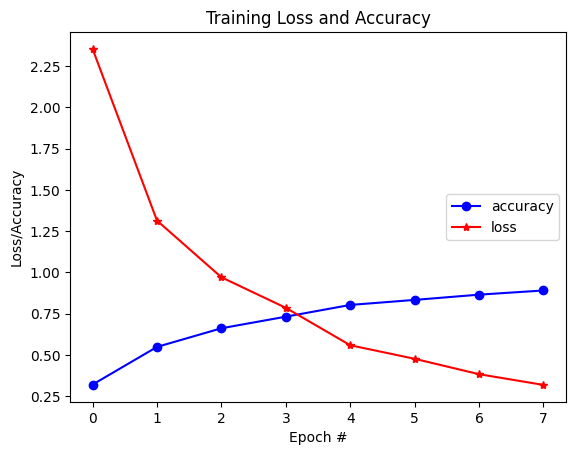

In [21]:
# Model accuracy and loss vs epoch
plt.plot(fit_cnn.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_cnn.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

# VGG19

## Now that we trained and saved the CNN model, we train a pre-trained model based on the VGG16 model.

In [22]:
base_model = VGG19(weights='imagenet', include_top=False) #imports the VGG19 model and discards the last layer.
x = base_model.output # (None, None, None, 512)
x = tf.keras.layers.GlobalAveragePooling2D()(x) # (None, 512)

x = Dropout(0.2)(x) # (None, 512)
x = Dense(256,activation='relu')(x) # (None, 256)
x = Dropout(0.2)(x) # (None, 256)

preds = Dense(num_classes,activation='softmax')(x) #final layer with softmax activation

model_vgg = Model(inputs=base_model.input, outputs=preds)

80134624/80134624 [==============================] - 4s 0us/step


In [23]:
base_model.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_2')>

We can print the layers of the full model as well as the base model only.

In [24]:
model_vgg.layers

In [25]:
base_model.layers

In [26]:
#Freeze layers from VGG16 backbone (not to be trained)
for layer in base_model.layers:
    layer.trainable=False

model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [27]:
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
%%time

num_epochs = 8

start_datetime = datetime.now()

fit_vgg = model_vgg.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_training,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_validation,
    verbose="auto",
)

end_datetime = datetime.now()
print('Training Duration: ' + str(end_datetime-start_datetime))

Epoch 1/8
484/484 [==============================] - 365s 753ms/step - loss: 1.7537 - accuracy: 0.4863 - val_loss: 0.8582 - val_accuracy: 0.7072
Epoch 2/8
484/484 [==============================] - 358s 740ms/step - loss: 0.9179 - accuracy: 0.6852 - val_loss: 0.6447 - val_accuracy: 0.7783
Epoch 3/8
484/484 [==============================] - 362s 748ms/step - loss: 0.7595 - accuracy: 0.7296 - val_loss: 0.5336 - val_accuracy: 0.8229
Epoch 4/8
484/484 [==============================] - 362s 748ms/step - loss: 0.6893 - accuracy: 0.7492 - val_loss: 0.5028 - val_accuracy: 0.8289
Epoch 5/8
484/484 [==============================] - 361s 747ms/step - loss: 0.6423 - accuracy: 0.7707 - val_loss: 0.5046 - val_accuracy: 0.8301
Epoch 6/8
484/484 [==============================] - 363s 749ms/step - loss: 0.5832 - accuracy: 0.7872 - val_loss: 0.5226 - val_accuracy: 0.8361
Epoch 7/8
484/484 [==============================] - 362s 747ms/step - loss: 0.5298 - accuracy: 0.8066 - val_loss: 0.4309 - val_ac

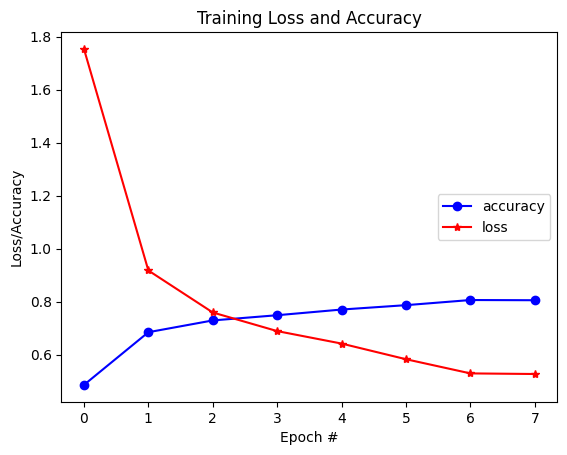

In [35]:
# Model accuracy and loss vs epoch
# Model accuracy and loss vs epoch
plt.plot(fit_vgg.history['accuracy'], '-bo', label="accuracy")
plt.plot(fit_vgg.history['loss'], '-r*', label="loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend(loc='center right')
plt.show()

In [34]:
# Save the model to a file
model_vgg.save('classifier_vgg_model.h5')

/Users/brncat/Downloads/AltaVerde/GitHub/Plant_Seedlings/plant_seedlings/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#  Persist the models and evaluate on the test set

In [3]:
# also run the first two cells to define file path and ramdom state 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg19 import preprocess_input

from keras.models import load_model

In this step we load the saved models and evaluate them on the test set

In [4]:
!ls 

__init__.py             classifier_vgg_model.h5 requirements.txt
classifier_cnn_model.h5 notebook.ipynb


In [4]:
# instantiate image data generator
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

image_resize = 224

test_dir = file_path+'test'


In [13]:
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(image_resize, image_resize),
    shuffle=True,
    batch_size = 1,
    class_mode='categorical',
    seed=rs
)

Found 837 images belonging to 12 classes.


In [14]:
print(test_generator.batch_size)

1


In [6]:
class_names = {y: x for x, y in test_generator.class_indices.items()}
class_names

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common_Chickweed',
 4: 'Common_wheat',
 5: 'Fat_Hen',
 6: 'Loose_Silky-bent',
 7: 'Maize',
 8: 'Scentless_Mayweed',
 9: 'Shepherd_Purse',
 10: 'Small-flowered_Cranesbill',
 11: 'Sugar_beet'}

In [7]:
# load the models

model_cnn = load_model('classifier_cnn_model.h5')

model_vgg = load_model('classifier_vgg_model.h5')

In [8]:
# Evaluate CNN on test_generator

test_generator.reset()
eval_cnn = model_cnn.evaluate(test_generator)
print('CNN Test loss: ', eval_cnn[0])
print('CNN Test Accuracy: ', eval_cnn[1])

837/837 [==============================] - 7s 9ms/step - loss: 0.8481 - accuracy: 0.7336
CNN Test loss:  0.8480780720710754
CNN Test Accuracy:  0.7335723042488098


In [22]:
# Evaluate pre-trained model on test_generator

test_generator.reset()
eval_vgg = model_vgg.evaluate(test_generator)
print('VGG19 Test loss: ', eval_vgg[0])
print('VGG19 Test Accuracy: ', eval_vgg[1])

837/837 [==============================] - 82s 98ms/step - loss: 0.4907 - accuracy: 0.8184
VGG19 Test loss:  0.49072015285491943
VGG19 Test Accuracy:  0.8183990716934204


## Plot the Confusion Matrix

We can plot the Confusion matrix, but first we redefine the test_generator with batch size equal to the number of images on the test set, which can be accessed by `test_generator.n`

In [15]:
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(image_resize, image_resize),
    shuffle=True,
    batch_size = test_generator.n , #The length of the test set to make easy plotting confusion matrix
    class_mode='categorical',
    seed=rs
)

Found 837 images belonging to 12 classes.


In [16]:
print(test_generator.batch_size)

837


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def conf_matrix_plot(model,x_data):
    '''
    Accepts as argument model object, and X data (test or validate) generator. 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
    y_data = np.argmax(x_data[0][1],axis=-1)
    model_pred = np.argmax(model.predict(x_data),axis=-1)
    cm = confusion_matrix(y_data, model_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  
    disp.plot()
    plt.show()


1/1 [==============================] - 8s 8s/step


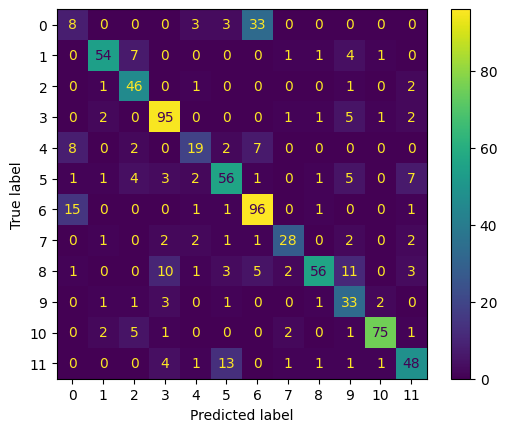

In [18]:
conf_matrix_plot(model_cnn, test_generator)

1/1 [==============================] - 122s 122s/step


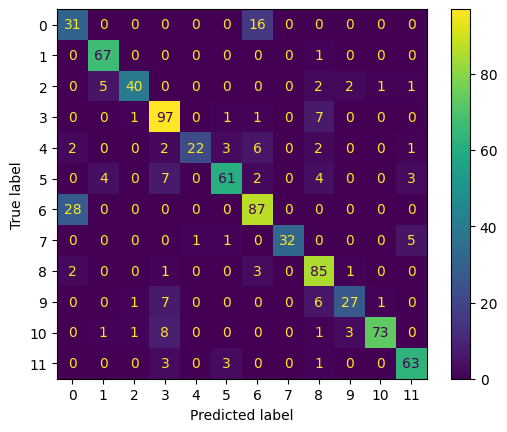

In [48]:
conf_matrix_plot(model_vgg, test_generator)

### We clearly see that the VGG19 pre-trained model performs much better than our defined CNN model.